# VGG16/2

## Data preparation

In [18]:
pip install colorama

In [34]:
from keras.datasets import mnist
from tensorflow.image import resize
from keras.utils import to_categorical
from colorama import Fore
import numpy as np

### 1. Load the MNIST dataset.

The **MNIST** dataset consists of 28x28 grayscale images, but VGG16 expects input images of size at least 32x32 and in three channels (RGB).

In [35]:
# Get data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Check if split ratio is correct
assert train_images.shape == (60000, 28, 28)
assert test_images.shape == (10000, 28, 28)
assert train_labels.shape == (60000,)
assert test_labels.shape == (10000,)

# Combine train and test sets
images = np.concatenate((train_images, test_images))
labels = np.concatenate((train_labels, test_labels))

print(f'{Fore.GREEN}Images loaded succesfully!{Fore.WHITE}')

Images loaded succesfully!


### 2. Resizing

Resizing the images from grayscale to RGB and adjusting them to the size compatible with VGG16 (we'll stick with 32x32 for this example).

In [36]:
# Resize images to 32x32 and convert to RGB by repeating the grayscale channel 3 times

images_rgb = np.repeat(images[..., np.newaxis], 3, axis=-1)
print("Shape before resizing:", images_rgb.shape)

Shape before resizing: (70000, 28, 28, 3)


In [37]:
images_resized = resize(images_rgb, [32, 32])
print("Shape before resizing:", images_resized.shape)

Shape before resizing: (70000, 32, 32, 3)


### 3. Normalizing the pixel value

VGG16 models usually work with pixel values in the range [0, 1] or [-1, 1]. We'll normalize our pixel values to [0, 1].

In [38]:
images_resized /= 255.0

### 4. Labels preparation

 Since VGG16 is a model used for classification tasks with more than 10 classes, ensure the labels are one-hot encoded.

In [39]:
y_one_hot = to_categorical(labels, 10)

### 5. Split dataset

Divide the dataset into training and validation sets with an 80/20 split.
Choose data randomly

In [40]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

# Convert TensorFlow tensors to numpy arrays if they are not already
images_resized_np = images_resized.numpy() if isinstance(images_resized, tf.Tensor) else images_resized
labels_one_hot_np = y_one_hot.numpy() if isinstance(y_one_hot, tf.Tensor) else y_one_hot

# Split the data randomly into training and validation sets with an 80/20 ratio
x_train_np, x_test_np, y_train_np, y_test_np = train_test_split(images_resized_np, labels_one_hot_np, test_size=0.2, random_state=42)

# If needed, convert back to TensorFlow tensors
x_train, x_test = tf.convert_to_tensor(x_train_np), tf.convert_to_tensor(x_test_np)
y_train, y_test = tf.convert_to_tensor(y_train_np), tf.convert_to_tensor(y_test_np)

print(f'Training set images shape: {x_train.shape}')
print(f'Validation set images shape: {x_test.shape}')
print(f'Training set labels shape: {y_train.shape}')
print(f'Validation set labels shape: {y_test.shape}')


Training set images shape: (56000, 32, 32, 3)
Validation set images shape: (14000, 32, 32, 3)
Training set labels shape: (56000, 10)
Validation set labels shape: (14000, 10)


## Building model

In [41]:
from keras.applications import VGG16
from keras import layers, models

In [42]:
# Load the VGG16 model pre-trained on ImageNet data, excluding the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the base model to prevent them from being updated during the first training phase
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
model = models.Sequential()

# Add the pre-trained VGG16 base model
model.add(base_model)

# Add new layers on top
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))  # 10 classes for digit classification

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
__________

# Train model

In [43]:
import time
import matplotlib.pyplot as plt
from keras.callbacks import History

In [44]:
# Measure the training time
start_time = time.time()

# Train the model
history = model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    verbose=1)

end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in: {training_time:.2f} seconds")

Epoch 1/15
875/875 [==============================] - 869s 992ms/step - loss: 0.4887 - accuracy: 0.8497 - val_loss: 0.2189 - val_accuracy: 0.9324
Epoch 2/15
875/875 [==============================] - 855s 977ms/step - loss: 0.2161 - accuracy: 0.9328 - val_loss: 0.1505 - val_accuracy: 0.9524
Epoch 3/15
875/875 [==============================] - 875s 999ms/step - loss: 0.1738 - accuracy: 0.9453 - val_loss: 0.1285 - val_accuracy: 0.9594
Epoch 4/15
875/875 [==============================] - 881s 1s/step - loss: 0.1525 - accuracy: 0.9513 - val_loss: 0.1161 - val_accuracy: 0.9630
Epoch 5/15
875/875 [==============================] - 809s 925ms/step - loss: 0.1397 - accuracy: 0.9554 - val_loss: 0.1070 - val_accuracy: 0.9665
Epoch 6/15
875/875 [==============================] - 855s 978ms/step - loss: 0.1293 - accuracy: 0.9582 - val_loss: 0.1058 - val_accuracy: 0.9659
Epoch 7/15
875/875 [==============================] - 855s 977ms/step - loss: 0.1216 - accuracy: 0.9611 - val_loss: 0.0991 - va

# Plots

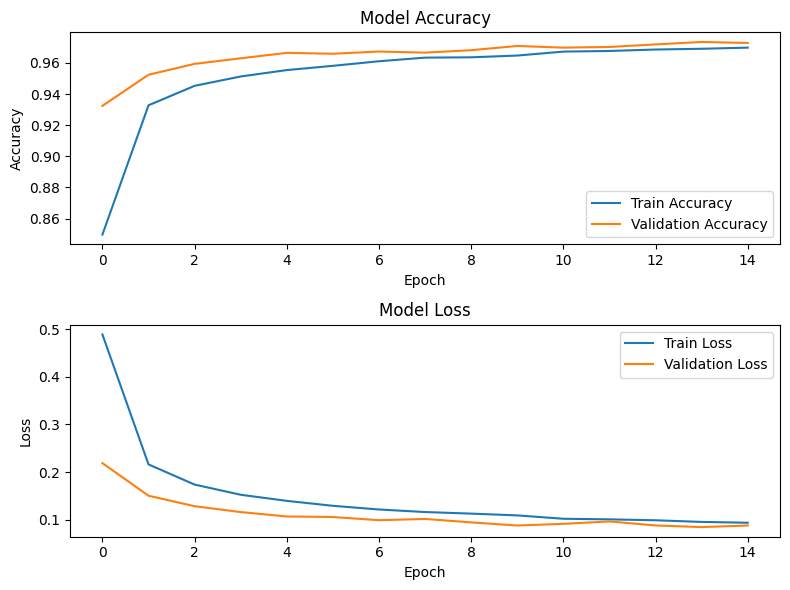

In [45]:
# Plotting training accuracy and loss
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Accuracy plot
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='lower right')

# Loss plot
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

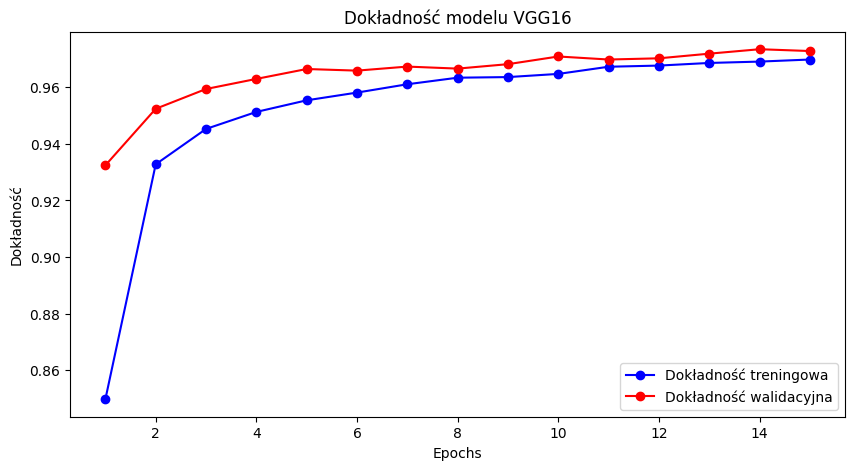

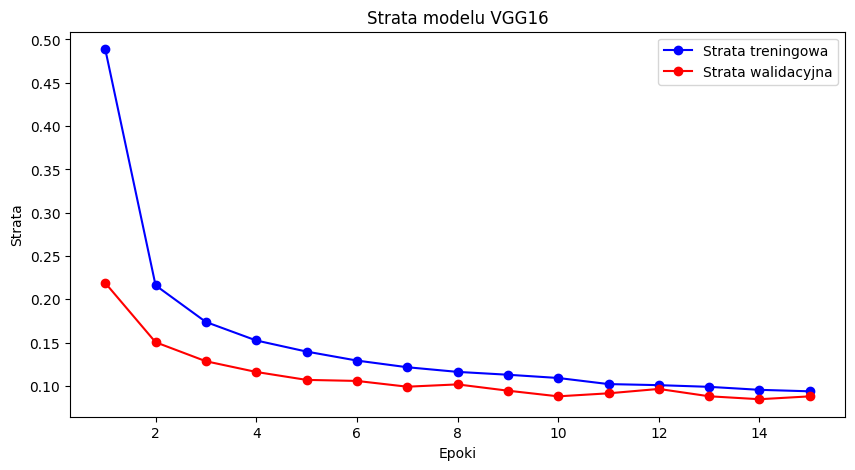

In [46]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'bo-', label='Dokładność treningowa')
plt.plot(epochs, val_acc, 'ro-', label='Dokładność walidacyjna')
plt.title('Dokładność modelu VGG16')
plt.xlabel('Epochs')
plt.ylabel('Dokładność')
plt.legend(loc='lower right')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo-', label='Strata treningowa')
plt.plot(epochs, val_loss, 'ro-', label='Strata walidacyjna')
plt.title('Strata modelu VGG16')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

In [47]:
model.save('vgg_16')

In [48]:
model.save('vgg_16.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
from keras.models import load_model

model1 = load_model('vgg_16')

In [50]:
# Print each layer's name and output shape
for layer in model1.layers:
    print(layer.name, layer.output_shape)

vgg16 (None, 1, 1, 512)
flatten (None, 512)
dense (None, 256)
dropout (None, 256)
dense_1 (None, 10)


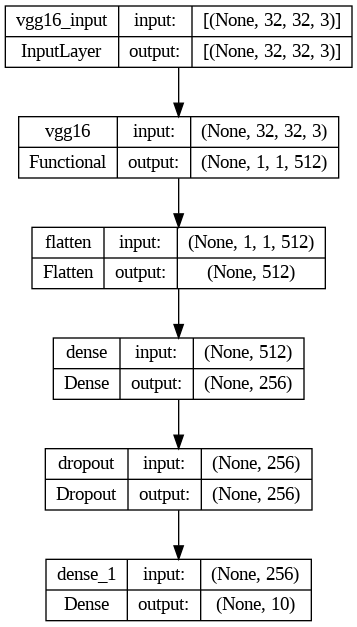

In [51]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [52]:
import pickle

# Assuming `history` is the object returned by model.fit()
with open('vgg16_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [53]:
with open('vgg16_history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

# Confusion Matrix

In [54]:
import numpy as np

start_time = time.time()

# Make predictions on the test set
predictions = model.predict(x_test)

end_time = time.time()
predicting_time = end_time - start_time
print(f"Prediction completed in: {predicting_time:.2f} seconds")

# Convert predictions and y_test to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)


438/438 [==============================] - 170s 388ms/step
Prediction completed in: 170.75 seconds


In [55]:
!pip install scikit-learn

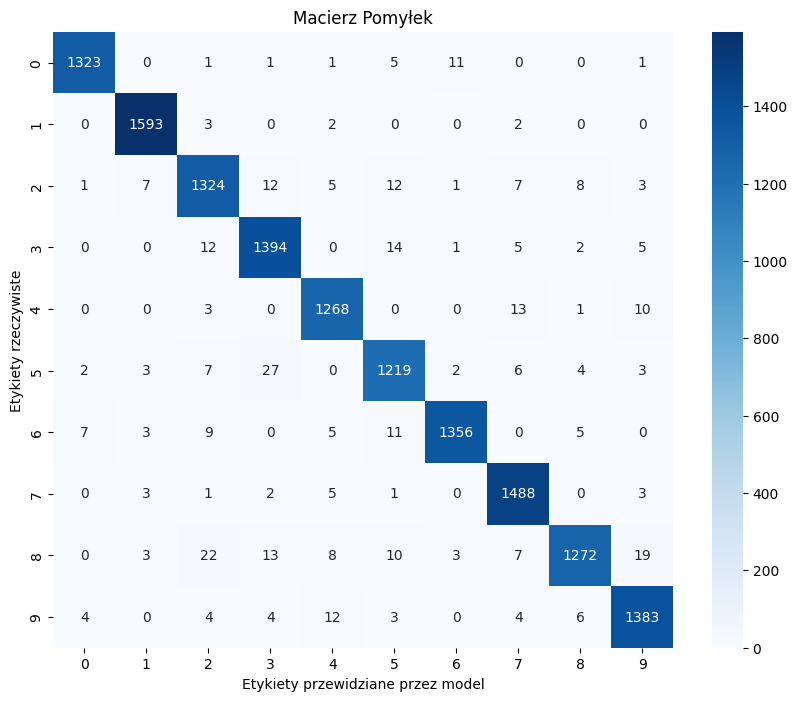

In [56]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Etykiety przewidziane przez model')
plt.ylabel('Etykiety rzeczywiste')
plt.title('Macierz Pomyłek')
plt.show()
